In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
mnist_data = pd.read_csv('mnist.csv').values
mnist_data

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0]])

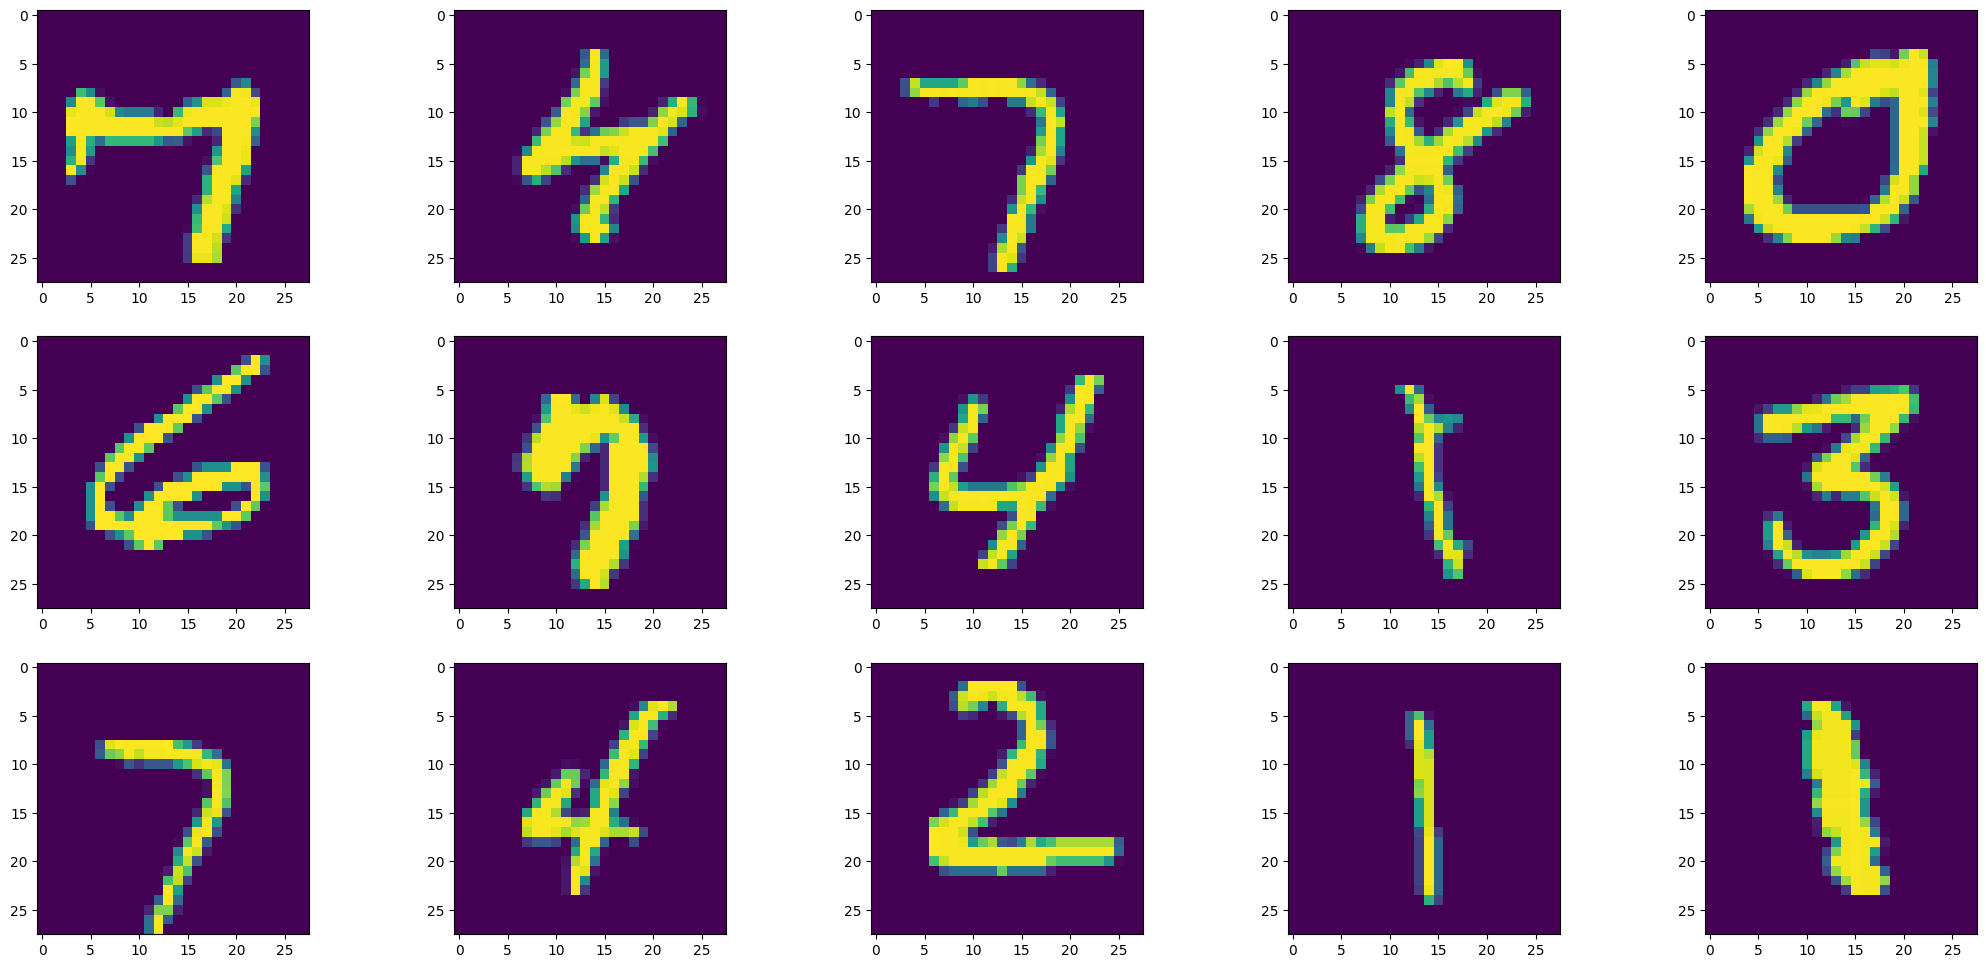

In [7]:
labels = mnist_data[:,0] # 0 to 9
digits = mnist_data[:, 1:] # 42000 digits
img_size = 28

fig = plt.figure(figsize=(26,12))
columns = 5
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(digits[random.randrange(0,len(digits))].reshape(img_size, img_size))
plt.show()

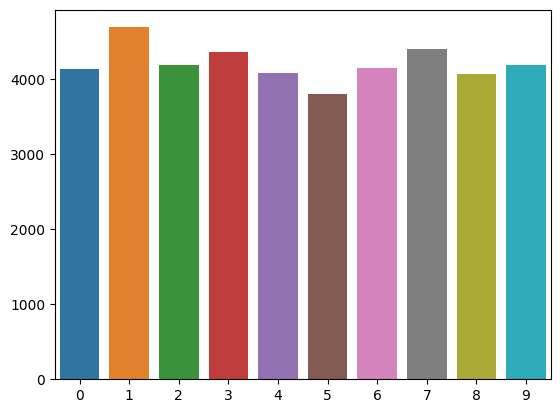

In [15]:
unique, counts = np.unique(labels, return_counts=True)
ax = sns.barplot(x=unique,y=counts)
plt.show()